get data 
make architecture 
loss function  - cross entropy 
move to tensor etc 
training loop
testing 

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import time

Download the data

In [3]:
mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

60000


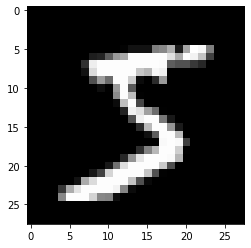

In [4]:
img, label = mnist[0]
plt.imshow(img[0,:,:],cmap = 'gray')
print(len(mnist))


# curated_mnist = []
# for i in range(len(mnist)):
#   if mnist[i][1] == 0 or mnist[i][1]== 1 or mnist[i][1]== 2 or mnist[i][1]== 3 or mnist[i][1]== 4 or mnist[i][1]== 5 or mnist[i][1]== 6:
#     curated_mnist.append(mnist[i])

# print(len(curated_mnist))
# for i in range(10):
#   img = curated_mnist[i][0]
#   plt.imshow(img[0,:,:],cmap = 'gray')
#   plt.show()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) 

#Parameters
batch_size = 128
numofClasses = 10
numofGenerators = 10
image_size = 28
image_channels = 1
noise_size = 10
noiseSizeperGen = 30
use_curated = False


lr_d = 2e-4
lr_g = 2e-4
beta1 = 0.5
num_epochs = 30


data_loader = DataLoader(mnist,batch_size,shuffle=True)
if use_curated:
    data_loader = DataLoader(curated_mnist,batch_size,shuffle=True)
# mnist.data.to(device)
# mnist.train_labels.to(device)
# print(mnist)


# for img_batch, label_batch in data_loader:
#   print(label_batch)
#   break

cuda


In [8]:
#Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:

#Generator
embed_dim = 50
#lowered from 25
ngf = 32
init_size = 10

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(numofGenerators,embed_dim)
        self.noise_seq = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(inplace = True)
        )
        self.main = nn.Sequential(
            #state size is 2*7*7
            nn.ConvTranspose2d( 150,ngf*8, kernel_size =4, stride = 1, padding = 0, bias=False),
                nn.BatchNorm2d(ngf*8),
                nn.LeakyReLU(0.3, inplace=True),
            #state size is (ngf*8)*14*14
            nn.ConvTranspose2d( ngf*8, ngf*4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ngf*4),
                nn.LeakyReLU(0.3, inplace=True),

            nn.ConvTranspose2d( ngf*4, ngf*2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf*2),
                nn.LeakyReLU(0.3, inplace=True),

            nn.ConvTranspose2d( ngf*2, 1, 4, 2, 1, bias=False),
                # nn.BatchNorm2d(ngf),
                # nn.LeakyReLU(0.3, inplace=True),
            #state size is (ngf*4)*28*28
            # nn.ConvTranspose2d(ngf*4, 1, 5, 1, 2, bias=False),

            # nn.BatchNorm2d(32),
            # nn.LeakyReLU(0.3,inplace=True),
            # nn.ConvTranspose2d(32, 1, 5, 1, 0, bias=False),
                nn.Tanh()
            #state size is 1*28*28
        )

    def forward(self,noise,label):
        embed = self.embedding(label)
        embed = torch.reshape(embed,(-1,50,1,1))
        # print("Embed shape: ", embed.shape)


        # noise = self.noise_seq(noise)
        # print("Noise shape: ", noise.shape)
        # noise = torch.reshape(noise,(-1,1,init_size,init_size))
        # print(noise.shape)
        embed = torch.cat((embed,noise),dim = 1)
        # print("Concat shape: ", embed.shape)
        x = self.main(embed)
        #x = self.network(noise)
        return x

In [10]:
# #Discriminator
# class Discriminator(nn.Module):
#   def __init__(self,n_Gen=numofGenerators):
#     super(Discriminator, self).__init__()
#     nc = 1
#     ndf = 16
#     self.main = nn.Sequential(
#             # input is 1 x 28 x 28
#             # nn.Conv2d(in_channels=nc, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.Conv2d(in_channels=nc, out_channels=ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.LeakyReLU(0.3, inplace=True),
#             # nn.Dropout(0.3),
#             # state size. 64 x 14 x 14
#             # nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
#             nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf*8),
#             nn.LeakyReLU(0.3, inplace=True),
        
#             nn.Conv2d(ndf*8, ndf*8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf*8),
#             nn.LeakyReLU(0.3, inplace=True),
#             # nn.Dropout(0.3)
#             # state size. 128 x 7 x 7    
#         )
#     #reshaping output to size equal to the number of generators + 1 (the true distribution)
#     self.out = nn.Linear(ndf*8*3*3,n_Gen+1)
#     # self.softmax = torch.nn.Softmax(dim = 1)

#   def forward(self,input):
#     #2 conv2d, leakyrelu
#     x = self.main(input)
#     m = nn.Flatten()
#     x = m(x)
#     x = self.out(x)
#     # x = self.softmax(x)
#     return x

#Discriminator
disc_embed_dim = 50
class Discriminator(nn.Module):
    def __init__(self,n_Gen=numofGenerators):
        super(Discriminator, self).__init__()
        nc = 2
        ndf = 16
        self.embedding = nn.Embedding(numofGenerators,disc_embed_dim)
        self.embed_linear = nn.Linear(50,28*28)
        self.main = nn.Sequential(
                # input is 1 x 28 x 28
                # nn.Conv2d(in_channels=nc, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
                nn.Conv2d(in_channels=nc, out_channels=ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.3, inplace=True),
                # nn.Dropout(0.3),
                # state size. 64 x 14 x 14
                # nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
                nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf*8),
                nn.LeakyReLU(0.3, inplace=True),

                nn.Conv2d(ndf*8, ndf*8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf*8),
                nn.LeakyReLU(0.3, inplace=True),
                # nn.Dropout(0.3)
                # state size. 128 x 7 x 7    
            )
        #reshaping output to size equal to the number of generators + 1 (the true distribution)
        self.out = nn.Linear(ndf*8*3*3,2) #only two categories now 
    # self.softmax = torch.nn.Softmax(dim = 1)

    def forward(self,input,label):
        embed = self.embedding(label)
        embed = self.embed_linear(embed)
        embed = torch.reshape(embed,(-1,1,28,28))
        x = torch.cat((embed,input),dim = 1)

        x = self.main(x)

        m = nn.Flatten()
        x = m(x)
        x = self.out(x)
        # x = self.softmax(x)
        return x
    
    

In [11]:
#Instantiate models,initialize weights and move to gpu
Gnet = Generator()
Gnet.apply(weights_init)
print(Gnet)

# noise = torch.zeros((2,1,noise_size,noise_size))
noise = torch.zeros((2,100,1,1))
print("noise shape: ", noise.shape)
labels = torch.LongTensor([0,0])
a = Gnet(noise,labels)
print(a.shape)

Dnet = Discriminator()
Dnet.apply(weights_init)
# print(Dnet)
b = Dnet(a,labels)
print(b.shape)

Gnet.to(device)
Dnet.to(device)

Generator(
  (embedding): Embedding(10, 50)
  (noise_seq): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(150, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.3, inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.3, inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.3, inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh(

Discriminator(
  (embedding): Embedding(10, 50)
  (embed_linear): Linear(in_features=50, out_features=784, bias=True)
  (main): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.3, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.3, inplace=True)
    (5): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.3, inplace=True)
  )
  (out): Linear(in_features=1152, out_features=2, bias=True)
)

In [12]:
#Loss function and optimizer
optimizer_g = torch.optim.Adam(Gnet.parameters(), lr = lr_g, betas =(beta1,0.999))
optimizer_d  = torch.optim.Adam(Dnet.parameters(), lr = lr_d, betas =(beta1,0.999))

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Generator params: ", count_parameters(Gnet))
print("Discriminator params: ", count_parameters(Dnet))

Generator params:  1043004
Discriminator params:  438566


In [14]:


log_soft_loss = nn.LogSoftmax(dim=1)
softmax_fx = torch.nn.Softmax(dim=1)
nll_fx = torch.nn.NLLLoss()

#Training loop

#Generator loss : -log(d(g(z)))
G_losses = []
#Discriminator loss: loss_d_fake + loss_d_real
D_losses = []
D_fake_losses = []
D_real_losses = []
#Probability of being real assigned to the real data
Real_data_realprob = []
#Probability of being real assigned to the fake data, from each generator
Generated_data_realprob = []
#Probability of being identified correctly from input, per generator
Correct_gen_prob = []


#to help visualize progression
img_list = []
#define a fixed noise
fixed_noise = torch.randn(10*numofGenerators, 100, 1, 1, device=device)
# fixed_labels = torch.full((100,),0,device = device)
fixed_labels = torch.full((10,),0,device = device)
for i in range(1,numofGenerators):
    fixed_labels = torch.cat((fixed_labels,torch.full((10,),i,device = device)))

print("Starting training loop.......")

Noise_labels = torch.full((noiseSizeperGen,),0,device = device)
for i in range(1,numofGenerators):
    Noise_labels = torch.cat((Noise_labels,torch.full((noiseSizeperGen,),i,device = device)))

disc_noise_labels = torch.full((noiseSizeperGen*numofGenerators,),0,device = device)

for epoch in range(num_epochs): 
    if num_epochs == 100:
        optimizer_g.param_groups[0]['lr'] = 2e-5
        optimizer_d.param_groups[0]['lr'] = 2e-5
    start = time.time()
    print("Epoch: ", epoch+1)

  #  gen_accuracies = []
  #  real_accuracy = 0

    loss_g_epoch = 0
    loss_d_epoch = 0
    loss_d_fake_epoch = 0
    loss_d_real_epoch = 0
    real_prob_epoch = 0
    grad_d = 0
    grad_g = 0
    
    
    gen_prob_epoch = 0
    correct_gen_prob_epoch = 0

    batchCounter = 0
    for i, data in enumerate(data_loader, 0):
        batchCounter+=1

        gen_accuracies = 0
        correct_gen_accuracies = 0
        real_accuracy = 0


        optimizer_d.zero_grad()


        #Generate noise
        NoiseShape =(noiseSizeperGen*numofGenerators,100,1,1)
        Noise = torch.randn(NoiseShape,device= device)
        
        gen_out =  Gnet(Noise,Noise_labels)  
        soft_out = softmax_fx(Dnet(gen_out,Noise_labels))
        
        gen_loss = nll_fx(torch.log(soft_out),disc_noise_labels)

        #For each generator
        loss_d_fake = 0
        

        gen_accuracies+=(torch.mean(soft_out[1]).item())
        correct_gen_accuracies+=(torch.mean(soft_out[0]).item())
#         for g in range(numofGenerators):

#             gen_accuracies.append(torch.mean(soft_out[g*noiseSizeperGen:(g+1)*noiseSizeperGen,-1]).item())
#             correct_gen_accuracies.append(torch.mean(soft_out[g*noiseSizeperGen:(g+1)*noiseSizeperGen,g]).item())


        loss_d_fake  = gen_loss
        gen_prob_epoch += gen_accuracies
        correct_gen_prob_epoch += correct_gen_accuracies

        #Get real data
        train_x, y = data
        train_x = train_x.to(device)
        train_y = y.to(device)
        
        disc_real_labels = torch.full(y.shape,1,device = device)

        #Get loss with respect to real 
        #  loss_d_real = loss_function(Dnet(train_x),real_labels)
        ### replacing this ###
        # soft_out = softmax_fx(Dnet(train_x))
        # real_accuracy = torch.mean(soft_out[:,-1]).item()
        # loss_d_real = nll_fx(torch.log(soft_out),real_labels)
        ### replacing this ###
        soft_out = softmax_fx(Dnet(train_x, train_y))
        real_accuracy = torch.mean(soft_out[:,-1]).item()
        
        loss_d_real = nll_fx(torch.log(soft_out),disc_real_labels)
        
        
        loss_d_total = (loss_d_fake + loss_d_real)
        loss_d_total.backward()

        grad_d+= torch.linalg.norm(Dnet.main[3].weight.grad.detach()).item()
        optimizer_d.step()


        #  Update G network : 
        optimizer_g.zero_grad()
        loss_g_total = 0

        disc_out = Dnet(Gnet(Noise,Noise_labels),Noise_labels) #make sure to pass the noise labels to the discrimnator too
        loss_g = log_soft_loss(disc_out)
        loss_g = -1*torch.mean(loss_g[:,-1])
        loss_g_total = loss_g
        loss_g_total.backward()
        grad_g+= torch.linalg.norm(Gnet.main[6].weight.grad.detach()).item()
        optimizer_d.step()
        optimizer_g.step()

        loss_d_epoch += loss_d_total
        loss_d_fake_epoch += loss_d_fake
        loss_d_real_epoch += loss_d_real
        loss_g_epoch += loss_g_total
        real_prob_epoch += real_accuracy

    G_losses.append(loss_g_epoch.item()/batchCounter)
    D_losses.append(loss_d_epoch.item()/batchCounter)
    D_fake_losses.append(loss_d_fake_epoch.item()/batchCounter)
    D_real_losses.append(loss_d_real_epoch.item()/batchCounter)

    Real_data_realprob.append(real_prob_epoch/batchCounter)
    Generated_data_realprob.append(gen_prob_epoch/batchCounter)
    Correct_gen_prob.append(correct_gen_prob_epoch/batchCounter)
    with torch.no_grad():
        fake = Gnet(fixed_noise,fixed_labels).detach().cpu()
    img_list.append(vutils.make_grid(fake,nrow=10, padding=2, normalize=True))


    #print(i/(len(data_loader.dataset)/batch_size))
    #  print("loss_d_fake ", loss_d_fake.item())
    #  print("loss_d_real ", loss_d_real.item())
    print("loss_d_total", D_losses[-1] , "loss_d_fake", D_fake_losses[-1],"loss_d_real",D_real_losses[-1],"loss_g_total", G_losses[-1])
    # print("loss_d_fake", D_fake_losses[-1])
    # print("loss_d_real",D_real_losses[-1])
    # print("loss_g_total", G_losses[-1])
    print("Generator accuracies: ", Generated_data_realprob[-1])
    print("Correct generator accuracies: ", Correct_gen_prob[-1])
    print("Real Data Accuracy: ", Real_data_realprob[-1])
    print("Norm of Gradient for G", grad_g/batchCounter, "Norm of Gradient for D", grad_d/batchCounter)
    # print("Norm of Gradient for D", grad_d/batchCounter)
    print("Time is " + str(time.time() - start))

Starting training loop.......
Epoch:  1
loss_d_total 0.9354568188632729 loss_d_fake 0.7177213819296375 loss_d_real 0.21773524172524653 loss_g_total 1.0126821033990205
Generator accuracies:  0.49999999720404653
Correct generator accuracies:  0.49999999771240167
Real Data Accuracy:  0.8114472525968734
Norm of Gradient for G 0.5447966735373174 Norm of Gradient for D 0.0867331128543628
Time is 17.1539306640625
Epoch:  2
loss_d_total 1.0581332534106809 loss_d_fake 0.7731446223472481 loss_d_real 0.28498833825084957 loss_g_total 0.8791516269447961
Generator accuracies:  0.4999999979030349
Correct generator accuracies:  0.4999999977759461
Real Data Accuracy:  0.7607091874964456
Norm of Gradient for G 0.3955141451440132 Norm of Gradient for D 0.10537097138811403
Time is 14.607498168945312
Epoch:  3
loss_d_total 1.181350545334155 loss_d_fake 0.8237196021496869 loss_d_real 0.3576312359970516 loss_g_total 0.7629391928471482
Generator accuracies:  0.4999999976488573
Correct generator accuracies:  0

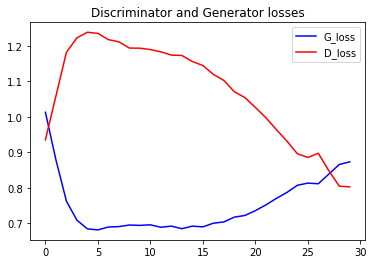

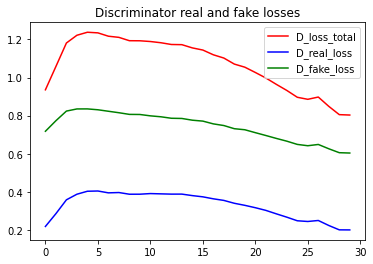

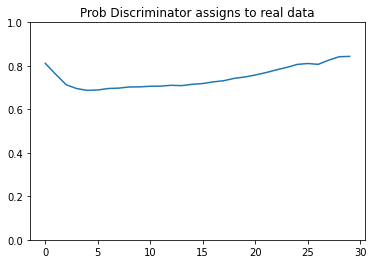

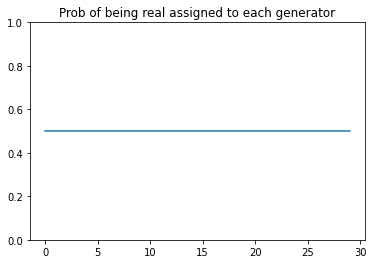

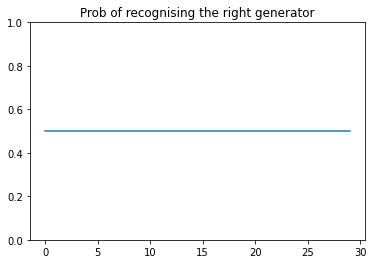

In [15]:
plt.plot(np.arange(len(G_losses)),G_losses,color = 'blue',label = "G_loss")
plt.plot(np.arange(len(D_losses)),D_losses,color = 'red',label = "D_loss")
plt.title("Discriminator and Generator losses")
plt.legend()
plt.show()

plt.plot(np.arange(len(D_losses)),D_losses,color = 'red',label = "D_loss_total")
plt.plot(np.arange(len(D_real_losses)),D_real_losses,color = 'blue',label = "D_real_loss")
plt.plot(np.arange(len(D_fake_losses)),D_fake_losses,color = 'green',label = "D_fake_loss")
plt.title("Discriminator real and fake losses")
plt.legend()
plt.show()

plt.plot(np.arange(len(Real_data_realprob)),Real_data_realprob)
plt.title("Prob Discriminator assigns to real data")
plt.ylim(0,1)
plt.show()

data = np.array(Generated_data_realprob)
plt.plot(np.arange(data.shape[0]),data)
plt.title("Prob of being real assigned to each generator")
plt.ylim(0,1)
plt.show()

data = np.array(Correct_gen_prob)
plt.plot(np.arange(data.shape[0]),data)
plt.title("Prob of recognising the right generator")
plt.ylim(0,1)
plt.show()

30


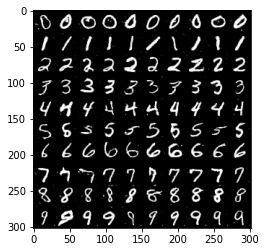

In [18]:
# fig = plt.figure(figsize=(10,10))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# HTML(ani.to_jshtml())

print(len(img_list))
e_index = 15
im = np.transpose(img_list[e_index],(1,2,0))
plt.imshow(im)
# plt.imsave('/notebooks/images/cGAN_'+str(e_index)+'_epoch.png',np.array(im))


In [53]:
import os
os.getcwd() 
os.listdir()

['cgan.ipynb',
 'very_promising-3-Copy1.ipynb',
 'cGAN_15_epoch.png',
 'images',
 'normal_gan.ipynb',
 'cGAN_25_epoch.png',
 'very_promising-3.ipynb',
 '.ipynb_checkpoints',
 'data']

0


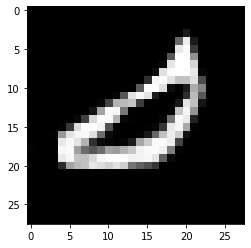

0


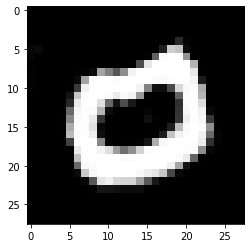

0


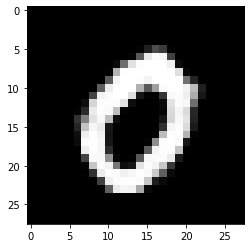

0


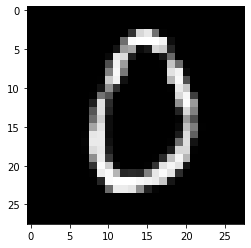

0


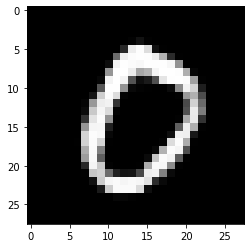

1


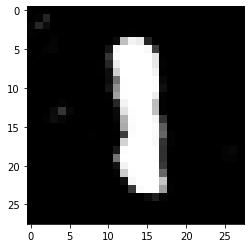

1


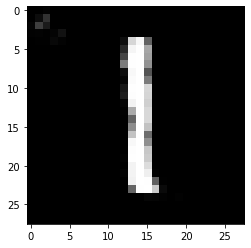

1


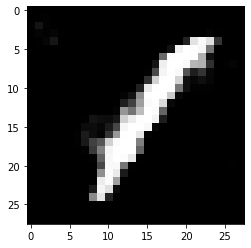

1


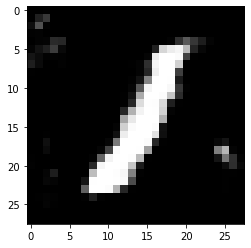

1


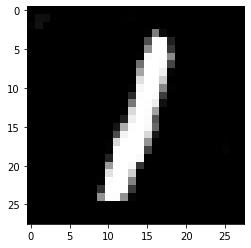

2


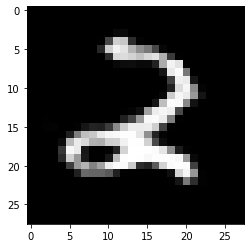

2


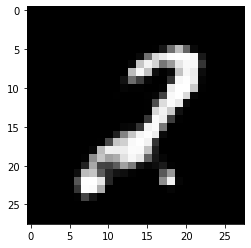

2


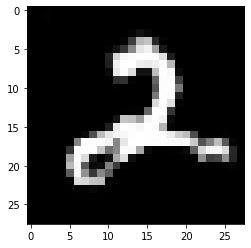

2


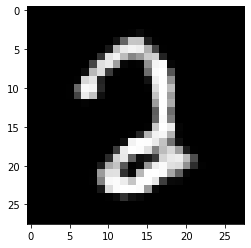

2


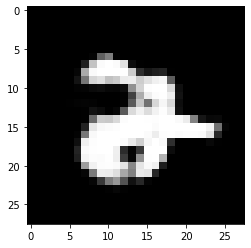

3


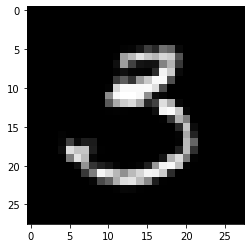

3


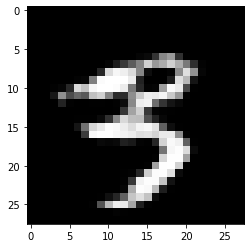

3


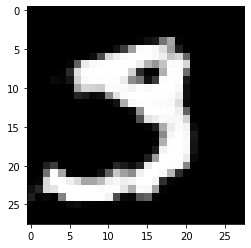

3


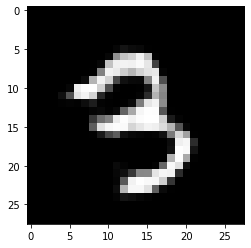

3


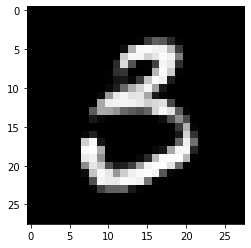

4


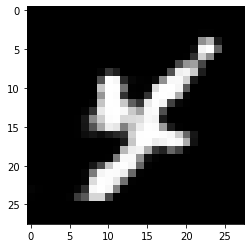

4


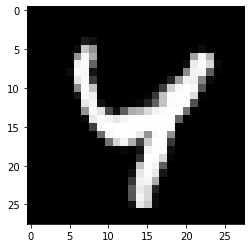

4


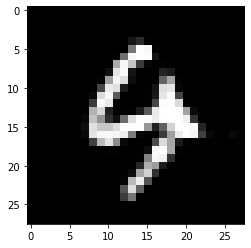

4


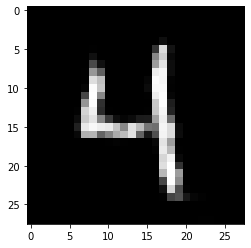

4


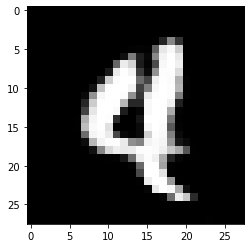

5


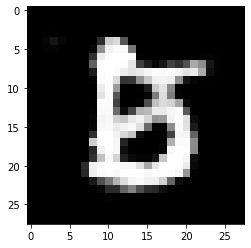

5


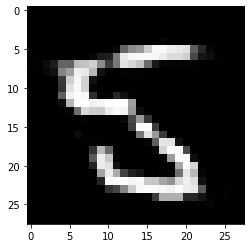

5


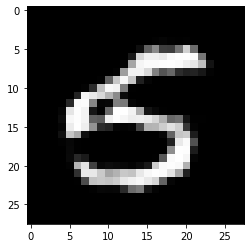

5


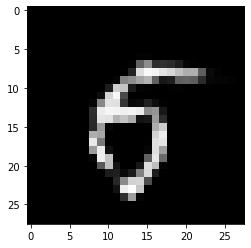

5


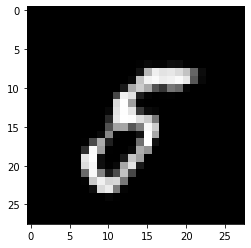

6


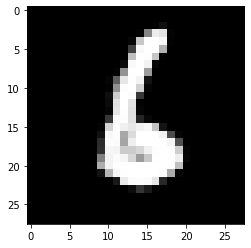

6


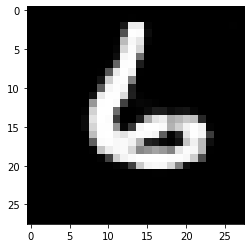

6


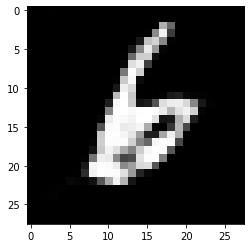

6


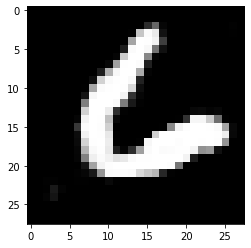

6


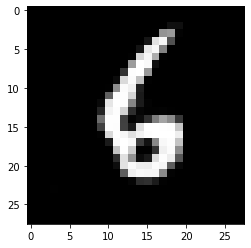

7


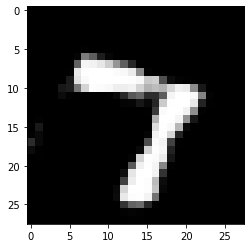

7


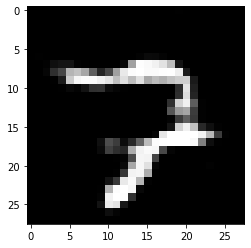

7


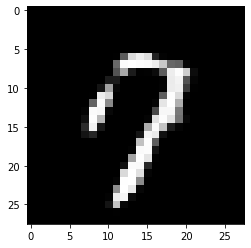

7


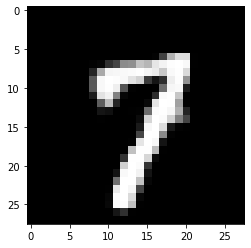

7


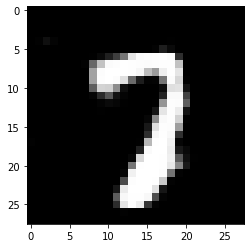

8


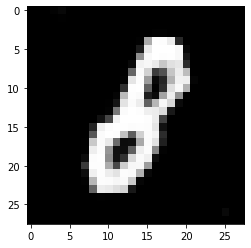

8


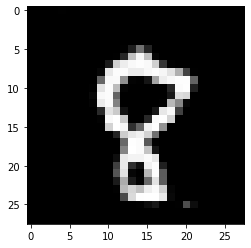

8


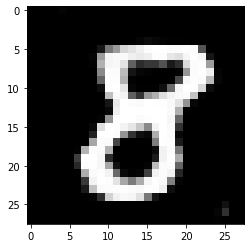

8


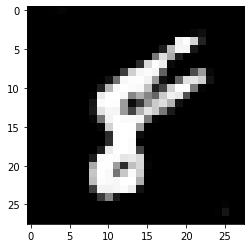

8


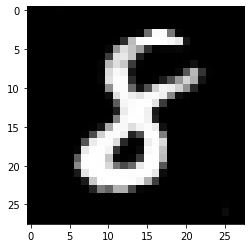

9


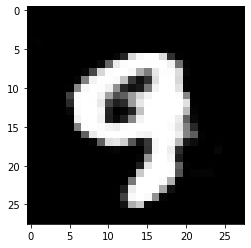

9


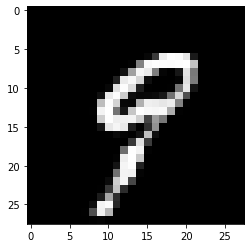

9


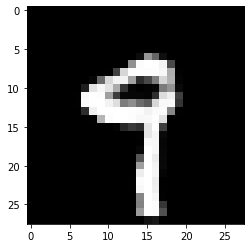

9


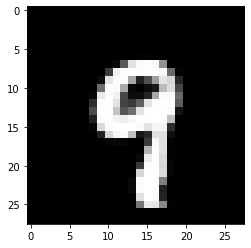

9


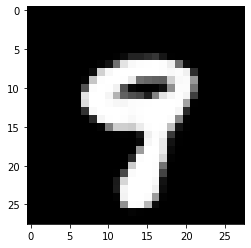

In [107]:
num_samples = 5
for i in range(0,numofGenerators):
  # noise = (torch.rand((100,1,5,5))*2)-1
    noise = torch.randn((num_samples,100,1,1))
    noise = noise.to(device)
    labels = torch.full((num_samples,1),i).to(device)
    output = Gnet(noise,labels)
    for j in range(num_samples):
        print(i)
        plt.imshow(output[j,0,:,:].cpu().detach().numpy(),cmap='gray')
        plt.show()

In [67]:
torch.save(Gnet.state_dict(), 'gen.pth')
torch.save(Dnet.state_dict(), 'disc.pth')

In [68]:
a = Gnet.embedding.weight.cpu().detach().numpy()
cross = a@a.T
print(cross)





# print(a.shape)
# for i in range(a.shape[0]):
#     embedding = a[i,:].cpu().detach().numpy()
#     embedding = embedding.reshape(7,7)
#     plt.imshow(embedding,cmap='gray')
#     plt.show()


    
    














[[ 1.16475456e+02 -3.48431855e-01 -3.22419517e-02  1.23814249e+01
   1.15968084e+01  1.60329056e+01  1.73864956e+01]
 [-3.48431855e-01  1.34803772e+02  2.05628414e+01  9.55982780e+00
   1.15348911e+01  1.57205534e+01  8.03722191e+00]
 [-3.22419517e-02  2.05628414e+01  1.57475937e+02  3.87201195e+01
   5.10224953e+01  1.94498211e-01 -5.72743082e+00]
 [ 1.23814249e+01  9.55982780e+00  3.87201195e+01  1.28889725e+02
   1.46811075e+01  1.26654015e+01 -7.62191010e+00]
 [ 1.15968084e+01  1.15348911e+01  5.10224953e+01  1.46811075e+01
   1.55970810e+02  1.51099520e+01 -5.43145990e+00]
 [ 1.60329056e+01  1.57205534e+01  1.94498211e-01  1.26654015e+01
   1.51099520e+01  1.09293907e+02 -1.65723395e+00]
 [ 1.73864956e+01  8.03722191e+00 -5.72743082e+00 -7.62191010e+00
  -5.43145990e+00 -1.65723395e+00  1.13947845e+02]]
